In [46]:
import sys
from generate_features import generate_features
import pandas as pd
import matplotlib.pyplot as plt
!{sys.executable} -m pip install statsmodels
## Import statistical package for Vector ARIMA
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

import numpy as np


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\danne\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import the Datasets

In [47]:
dataset_paths = ["./USDCHF=X.csv", "./Gold_USD.csv", "./SP500.csv", "./SMI.csv"]
dataset_names = [path.split("./")[-1].split(".")[0] for path in dataset_paths]
# Remove =X from the name of USDCHF dataset
dataset_names[0] = dataset_names[0].split("=")[0]
datasets = {}
## Read in the datasets
for ds_name, ds_path in zip(dataset_names, dataset_paths):
    entire_dataset = pd.read_csv(ds_path, parse_dates=['Date'])
    # Drop all but the date and close columns
    datasets[ds_name] = entire_dataset[['Date', 'Close']]
print(dataset_names)

['USDCHF', 'Gold_USD', 'SP500', 'SMI']


### Join the Datasets

In [48]:
# Perform inner join to add the closing price for each dataset into a single df
merged_dataset = datasets[dataset_names[0]]
for ds_name in dataset_names[1:]:
    datasets[ds_name] = datasets[ds_name].rename(columns={"Close": ds_name})
    merged_dataset = merged_dataset.merge(datasets[ds_name], on='Date',how='inner')

print(f"USD/CHF after merge: {merged_dataset.shape}")
print(merged_dataset.head())

USD/CHF after merge: (247, 5)
        Date    Close     Gold_USD        SP500           SMI
0 2022-10-03  0.98565  1692.900024  3678.429932  10290.709961
1 2022-10-04  0.99256  1721.099976  3790.929932  10590.919922
2 2022-10-05  0.97869  1711.400024  3783.280029  10477.690430
3 2022-10-06  0.98132  1711.699951  3744.520020  10391.129883
4 2022-10-07  0.98997  1700.500000  3639.659912  10308.570313


### Test Causality between the Various Time Series

In [49]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [50]:
df_no_date = merged_dataset.drop(["Date"], axis=1)
grangers_causation_matrix(df_no_date, variables = df_no_date.columns)

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is d

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is d

,Close_x,Gold_USD_x,SP500_x,SMI_x
Close_y,1.0000,0.0000,0.0000,0.0091
Gold_USD_y,0.0710,1.0000,0.2871,0.5309
SP500_y,0.0005,0.1089,1.0000,0.3231
SMI_y,0.3118,0.0274,0.0001,1.0000


### Test Stationary of the Time-Series Datasets

#### Create clone of dataset before it is differenced

In [51]:
undifferenced_df = merged_dataset.copy()

In [52]:
### Tests stationarity of a given signal using the adfuller test
def test_stationarity(time_series_ds, time_series_name, signif_threshold=0.05, ):
    print(f"\n\n\t\t Running Augmented Dickey-Fuller test on {time_series_name}")
    print("-"*80)
    adfuller_result = adfuller(time_series_ds, autolag='AIC')
    significance = round(adfuller_result[1], 5)
    print(f"P-value: {significance}")
    if significance < signif_threshold:
        print(f"P-value less than {signif_threshold} threshold. Null hypothesis rejected")
        print("Provided Time-Series is Stationary")
        return True
    else: 
        print(f"P-value exceeds {signif_threshold}. There is insufficient evidence to reject the null hypothesis.")
        print(f"Provided Time-Series Assumed Non-Stationary")
        return False

In [53]:
## Run stationary test on training portion of each individual dataset
print(merged_dataset)
print(f"dataset names:  {dataset_names}")
stationary_dict = {}
for col_name in merged_dataset.columns:
    if col_name != "Date":
        next_time_series = merged_dataset[col_name]
        is_stationary = test_stationarity(next_time_series, col_name)
        # Keep track of which time series are stationary to determine which signals
        # must be differenced.
        stationary_dict[col_name] = is_stationary

          Date    Close     Gold_USD        SP500           SMI
0   2022-10-03  0.98565  1692.900024  3678.429932  10290.709961
1   2022-10-04  0.99256  1721.099976  3790.929932  10590.919922
2   2022-10-05  0.97869  1711.400024  3783.280029  10477.690430
3   2022-10-06  0.98132  1711.699951  3744.520020  10391.129883
4   2022-10-07  0.98997  1700.500000  3639.659912  10308.570313
..         ...      ...          ...          ...           ...
242 2023-09-26  0.91208  1900.400024  4273.529785  10953.700195
243 2023-09-27  0.91576  1871.599976  4274.509766  10882.309570
244 2023-09-28  0.92082  1860.400024  4299.700195  10917.790039
245 2023-09-29  0.91476  1848.099976  4288.049805  10963.500000
246 2023-10-02  0.91548  1830.000000  4288.390137  10863.650391

[247 rows x 5 columns]
dataset names:  ['USDCHF', 'Gold_USD', 'SP500', 'SMI']


		 Running Augmented Dickey-Fuller test on Close
--------------------------------------------------------------------------------
P-value: 0.40201
P-va

### Perform Differencing to Enforce Stationarity

In [54]:
for col_name in merged_dataset.columns:
    if col_name != "Date":
        is_stationary = stationary_dict[col_name]
        if not is_stationary:
            differenced_col = merged_dataset[col_name].diff()
            print("Differenced column before dropping na: ")
            print(differenced_col)
            # Drop any na terms resulting from differencing operation
            print("difference column after dropping na: ")
            print(differenced_col)
            merged_dataset[col_name] = differenced_col
            merged_dataset = merged_dataset.dropna()
            print("\n\nMerged dataset column: ")
            print(merged_dataset[col_name])

#     train_set = train_test_dict[ds_name]["train"]
#     # print(train_set)
#     differenced_close= train_set["Close"].diff()
#     # Drop any na terms resulting from differencing operation
#     differenced_close = differenced_close.dropna()
#     # Replace old column with the differenced column
#     train_ds = train_test_dict[ds_name]["train"] 
#     train_ds.update(differenced_close)
#     train_test_dict[ds_name]["train"] = train_ds
# print(train_test_dict)

Differenced column before dropping na: 
0          NaN
1      0.00691
2     -0.01387
3      0.00263
4      0.00865
        ...   
242    0.00498
243    0.00368
244    0.00506
245   -0.00606
246    0.00072
Name: Close, Length: 247, dtype: float64
difference column after dropping na: 
0          NaN
1      0.00691
2     -0.01387
3      0.00263
4      0.00865
        ...   
242    0.00498
243    0.00368
244    0.00506
245   -0.00606
246    0.00072
Name: Close, Length: 247, dtype: float64


Merged dataset column: 
1      0.00691
2     -0.01387
3      0.00263
4      0.00865
5      0.00459
        ...   
242    0.00498
243    0.00368
244    0.00506
245   -0.00606
246    0.00072
Name: Close, Length: 246, dtype: float64
Differenced column before dropping na: 
1            NaN
2      -9.699952
3       0.299927
4     -11.199951
5     -33.199951
         ...    
242   -16.199952
243   -28.800048
244   -11.199952
245   -12.300048
246   -18.099976
Name: Gold_USD, Length: 246, dtype: float64
differe

### Check that all Time-series are now all Stationary

In [55]:
## Run stationary test on training portion of each individual dataset
print(merged_dataset)
for col_name in merged_dataset.columns:
    if col_name != "Date":
        next_time_series = merged_dataset[col_name]
        test_stationarity(next_time_series, col_name)

          Date    Close   Gold_USD       SP500           SMI
3   2022-10-06  0.00263   0.299927  -38.760009  10391.129883
4   2022-10-07  0.00865 -11.199951 -104.860108  10308.570313
5   2022-10-10  0.00459 -33.199951  -27.270019  10262.519531
6   2022-10-11  0.00495  11.399902  -23.549805  10207.830078
7   2022-10-12 -0.00191  -8.399902  -11.810059  10199.320313
..         ...      ...        ...         ...           ...
242 2023-09-26  0.00498 -16.199952  -63.910156  10953.700195
243 2023-09-27  0.00368 -28.800048    0.979981  10882.309570
244 2023-09-28  0.00506 -11.199952   25.190429  10917.790039
245 2023-09-29 -0.00606 -12.300048  -11.650390  10963.500000
246 2023-10-02  0.00072 -18.099976    0.340332  10863.650391

[244 rows x 5 columns]


		 Running Augmented Dickey-Fuller test on Close
--------------------------------------------------------------------------------
P-value: 0.0
P-value less than 0.05 threshold. Null hypothesis rejected
Provided Time-Series is Stationary


		 

### Perform Train/Test Data Split

In [56]:
days_to_predict = 5
### Create a nested dictionary which stores the training and testing set for
### each dataset
df = merged_dataset.copy()
train_set, test_set = df[:-days_to_predict].reset_index(drop=True), df[-days_to_predict:].reset_index(drop=True)

print(f"Train set shape: {train_set.shape}")
print(f"Train set head:\n {train_set.head()}\n")
print(f"Test set shape: {test_set.shape}")
print(f"Test set head:\n {test_set.head()}\n")


Train set shape: (239, 5)
Train set head:
         Date    Close   Gold_USD       SP500           SMI
0 2022-10-06  0.00263   0.299927  -38.760009  10391.129883
1 2022-10-07  0.00865 -11.199951 -104.860108  10308.570313
2 2022-10-10  0.00459 -33.199951  -27.270019  10262.519531
3 2022-10-11  0.00495  11.399902  -23.549805  10207.830078
4 2022-10-12 -0.00191  -8.399902  -11.810059  10199.320313

Test set shape: (5, 5)
Test set head:
         Date    Close   Gold_USD      SP500           SMI
0 2023-09-26  0.00498 -16.199952 -63.910156  10953.700195
1 2023-09-27  0.00368 -28.800048   0.979981  10882.309570
2 2023-09-28  0.00506 -11.199952  25.190429  10917.790039
3 2023-09-29 -0.00606 -12.300048 -11.650390  10963.500000
4 2023-10-02  0.00072 -18.099976   0.340332  10863.650391



### Train the Model with Only Endogenous Variables

In [24]:
p = np.arange(1,5)
q = np.arange(1,5)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(train_set.drop(['Date'], axis=1), order=(i,j), seasonal_order=(0,0,0,0), mle_regression = True, filter_concentrated = True)
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = train_set.iloc[-1]['Close'] + model_fit.forecast(5).reset_index(drop=True).Close
        pred['observed'] = test_set.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_order', 'mle_regression']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not 

##### Extract the Model with Lowest MSE on Training Set

In [25]:
model_fit_endog = models[np.argmin(MSEs)]

#### Plot the Predictions vs. Observations

In [41]:
# plot prediction vs observed
def plot_predictions(train_set, test_set, model_fit):
    pred = pd.DataFrame()
    pred['prediction'] = train_set.iloc[-1]['Close'] + model_fit.forecast(5, exog=test_set[['Gold_USD', 'SMI']]).reset_index(drop=True).Close
    pred['observed'] = test_set.reset_index(drop=True).Close

    pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
    plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

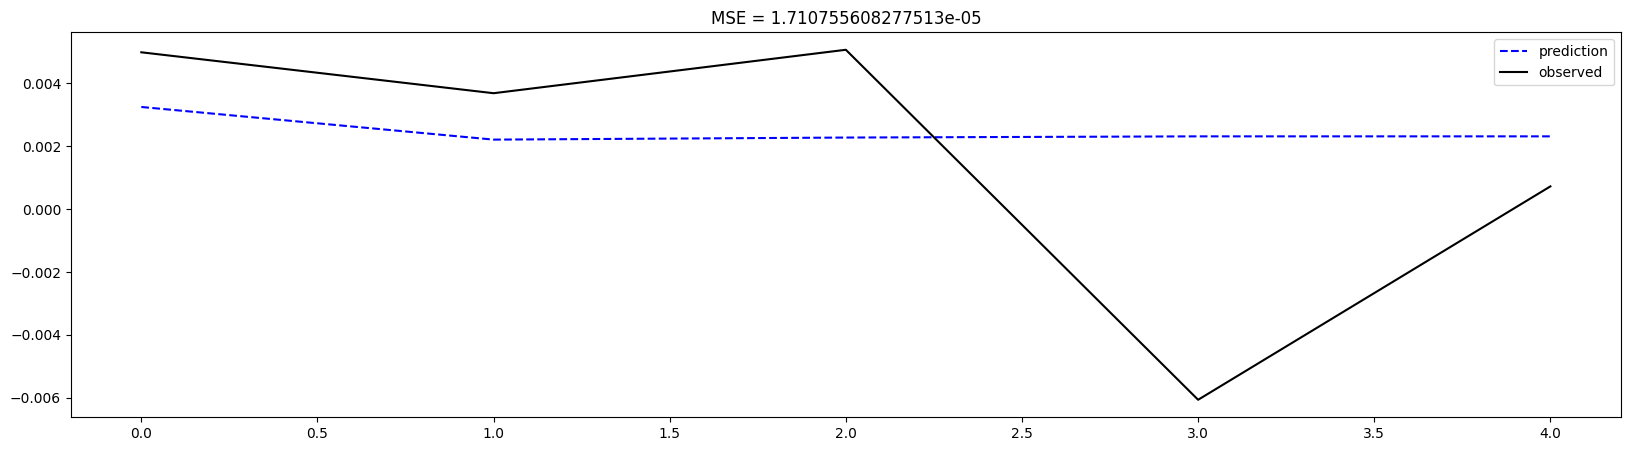

In [27]:
plot_predictions(train_set, test_set, model_fit_endog)

In [30]:
print(train_set.drop(['Date'], axis=1))

       Close   Gold_USD       SP500           SMI
0    0.00263   0.299927  -38.760009  10391.129883
1    0.00865 -11.199951 -104.860108  10308.570313
2    0.00459 -33.199951  -27.270019  10262.519531
3    0.00495  11.399902  -23.549805  10207.830078
4   -0.00191  -8.399902  -11.810059  10199.320313
..       ...        ...         ...           ...
234  0.00037   0.500000   -9.579590  11068.700195
235  0.00006  13.599976  -41.750000  11154.110352
236  0.00189 -26.400025  -72.200195  11084.740234
237  0.00527   6.200073   -9.939941  11014.759766
238  0.00263  -8.800048   17.379882  11014.259766

[239 rows x 4 columns]


### Train the Model with Gold and SMI as Exogenous Variables

In [83]:
p = np.arange(6,11)
q = np.arange(6,11)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        # model = VARMAX(endog=train_set[['Close', 'SP500']], order=(i,j), exog=train_set[['Gold_USD', 'SMI']], seasonal_order=(0,0,0,0), mle_regression = True, filter_concentrated = True)
        model = VARMAX(endog=train_set[['Close', 'SP500']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=train_set[['Gold_USD', 'SMI']])
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = train_set.iloc[-1]['Close'] + model_fit.forecast(5, exog=test_set[['Gold_USD', 'SMI']]).reset_index(drop=True).Close
        pred['observed'] = test_set.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['mle_regression']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

##### Select the most accurate model

In [39]:
model_fit_exog = models[np.argmin(MSEs)]

#### Plot the predicted vs. the observed

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_order', 'mle_regression']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not 

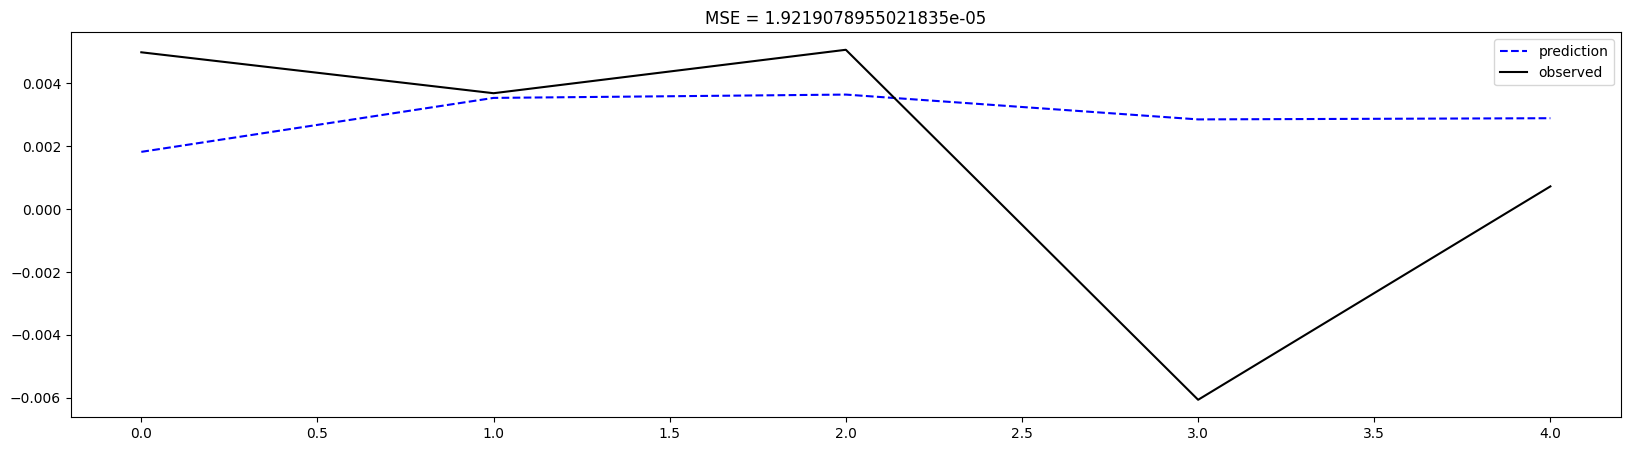

In [42]:
plot_predictions(train_set, test_set, model_fit_exog)

### Undo Differencing to Return to data's initial domain


In [78]:
def undo_differencing(pred_df, train_set, undifferenced_df, stationary_dict):
    close_was_differenced = not stationary_dict['Close']
    if close_was_differenced:
        undifferenced_pred = pd.DataFrame()
        undifferenced_pred['predictions'] = pred_df['prediction'].cumsum() + undifferenced_df['Close'].iloc[-1]
        undifferenced_pred['observations'] = undifferenced_df[-days_to_predict:].reset_index(drop=True).Close
        return undifferenced_pred

In [79]:
undiff_pred = undo_differencing(pred, train_set, undifferenced_df, stationary_dict)

### Plot after differencing removed

Text(0.5, 1.0, 'MSE = 9.28438988814237e-05')

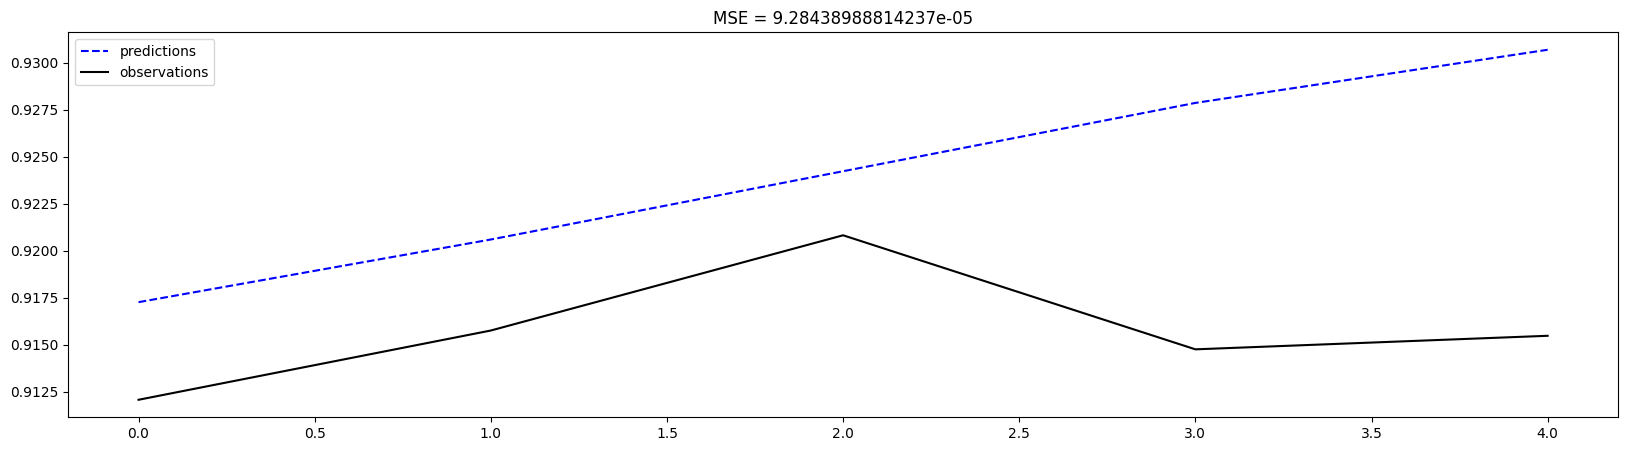

In [81]:
undiff_pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
plt.title(f"MSE = {np.mean((undiff_pred['predictions'].values-undiff_pred['observations'].values)**2)}")